# Combine Binance and Twitter data

In [47]:
# Load libraries
import numpy as np
import pandas as pd
from pandas import json_normalize
from tqdm import tqdm
tqdm.pandas()

pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns',500)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(13,6)})

import plotly.express as px
import plotly.graph_objects as go

## Load Binance dataset

In [30]:
# Binance
binance_df = pd.read_csv("../data/eth-usdt-daily-data.csv", index_col=0)

In [31]:
binance_df.shape

(290, 17)

In [32]:
binance_df.head()

open_time               close_time  \
2020-12-10 01:59:59.999  2020-12-09 00:00:00.000  2020-12-09 23:59:59.999   
2020-12-11 01:59:59.999  2020-12-10 00:00:00.000  2020-12-10 23:59:59.999   
2020-12-12 01:59:59.999  2020-12-11 00:00:00.000  2020-12-11 23:59:59.999   
2020-12-13 01:59:59.999  2020-12-12 00:00:00.000  2020-12-12 23:59:59.999   
2020-12-14 01:59:59.999  2020-12-13 00:00:00.000  2020-12-13 23:59:59.999   

                             open      high       low     close       volume  \
2020-12-10 01:59:59.999 554.92000 578.08000 530.43000 573.09000 997192.16738   
2020-12-11 01:59:59.999 573.20000 575.70000 548.11000 558.99000 608414.51466   
2020-12-12 01:59:59.999 558.99000 560.80000 535.50000 544.43000 768921.78317   
2020-12-13 01:59:59.999 544.46000 574.00000 543.10000 568.04000 573913.95311   
2020-12-14 01:59:59.999 568.09000 595.00000 563.22000 590.70000 657794.46158   

                         num_trades  MA_10  STD_10  Price_Change  \
2020-12-10 01:59:59.999      535975    NaN     NaN           NaN   
2020-12-11 01:59:59.999      376548    NaN     NaN     -14.10000   
2020-12-12 01:59:59.999      400545    NaN     NaN     -14.56000   
2020-12-13 01:59:59.999      321104    NaN     NaN      23.61000   
2020-12-14 01:59:59.999      359525    NaN     NaN      22.66000   

                         Price_Change%   Change  upper_bound  lower_bound  \
2020-12-10 01:59:59.999            NaN      NaN          NaN          NaN   
2020-12-11 01:59:59.999       -2.46000  Neutral          NaN          NaN   
2020-12-12 01:59:59.999       -2.60000  Neutral          NaN          NaN   
2020-12-13 01:59:59.999        4.34000  Neutral          NaN          NaN   
2020-12-14 01:59:59.999        3.99000  Neutral          NaN          NaN   

                         above_bound  below_bound  
2020-12-10 01:59:59.999        False        False  
2020-12-11 01:59:59.999        False        False  
2020-12-12 01:59:59.999        False        False  
2020-12-13 01:59:59.999        False        False  
2020-12-14 01:59:59.999        False        False

In [33]:
# Create open_time_date column
binance_df["open_time_date"] = pd.to_datetime(binance_df["open_time"])

In [34]:
binance_df.dtypes

open_time                 object
close_time                object
open                     float64
high                     float64
low                      float64
close                    float64
volume                   float64
num_trades                 int64
MA_10                    float64
STD_10                   float64
Price_Change             float64
Price_Change%            float64
Change                    object
upper_bound              float64
lower_bound              float64
above_bound                 bool
below_bound                 bool
open_time_date    datetime64[ns]
dtype: object

In [51]:
## Conclusions

# - There aren't any day crossing both upper and low bound!
# - There are 38 days crossing above bound
# - There are 31 days crossing below bound

binance_df[["above_bound", "below_bound"]].value_counts()

above_bound  below_bound
False        False          221
True         False           38
False        True            31
dtype: int64

In [60]:
# Create cross_bounds columns [above, below, neutral]

def create_cross_bounds(row):
    if row['above_bound'] :
        return 'above'
    elif row['below_bound'] :
        return 'below'
    else:
        return "neutral"
    
binance_df["cross_bounds"] = binance_df.apply(lambda row: create_cross_bounds(row), axis=1)

## Load twitter dataset

In [7]:
tweets_df = pd.read_pickle("../data/tweets_df_sentiment.pkl")

In [8]:
tweets_df.shape

(1689943, 12)

In [9]:
tweets_df.head()

author_id                created_at             tweet_id  \
0  1334365558259679238 2021-01-01 00:59:21+00:00  1344810410805919745   
1            862148214 2021-01-01 00:59:17+00:00  1344810392594202624   
2  1339254429862727681 2021-01-01 00:59:14+00:00  1344810380909043717   
3  1129381702407741441 2021-01-01 00:58:52+00:00  1344810289204764674   
4           2933596550 2021-01-01 00:58:47+00:00  1344810265884430336   

                                                text  like_count  quote_count  \
0  i've got a discount running on the nootropic i...           0            0   
1  happy new year everyone. \n\nhttps://t.co/v0yx...           0            0   
2  2020 recap\n\n3 artists (roberto hernández, 3p...           1            0   
3  analytics firm reveals that whales are startin...           0            0   
4  happy new year #swapfolio community!\n\nthanks...           9            0   

   reply_count  retweet_count created_at_date created_at_date_hour  sentiment  \
0            0              0      2021-01-01         2021-01-01 0   -0.23714   
1            0              0      2021-01-01         2021-01-01 0   -0.44242   
2            0              0      2021-01-01         2021-01-01 0    0.88306   
3            0              0      2021-01-01         2021-01-01 0    0.23561   
4            0              4      2021-01-01         2021-01-01 0   -0.36963   

  sentiment_val  
0      negative  
1      negative  
2      positive  
3      positive  
4      negative

In [10]:
# Fix date column
tweets_df["created_at_date"] = pd.to_datetime(tweets_df["created_at_date"])

In [11]:
tweets_df.dtypes

author_id                             int64
created_at              datetime64[ns, UTC]
tweet_id                              int64
text                                 object
like_count                            int64
quote_count                           int64
reply_count                           int64
retweet_count                         int64
created_at_date              datetime64[ns]
created_at_date_hour                 object
sentiment                           float64
sentiment_val                      category
dtype: object

In [12]:
# Create weighted_sentiment
tweets_df["weighted_sentiment"] = tweets_df["sentiment"] * (tweets_df["like_count"]+tweets_df["retweet_count"])

In [13]:
tweets_df[["sentiment","weighted_sentiment"]].describe()

sentiment  weighted_sentiment
count 1689943.00000       1689943.00000
mean        0.00001             0.09399
std         0.57740           132.38472
min        -1.00000        -37172.56770
25%        -0.50032             0.00000
50%         0.00011            -0.00000
75%         0.49999            -0.00000
max         1.00000         63927.99391

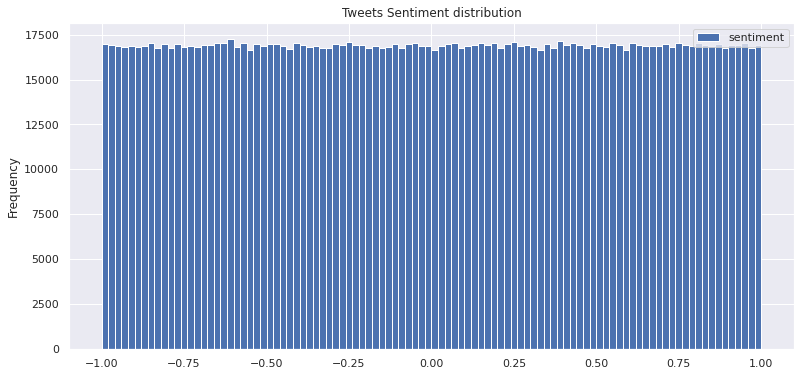

In [14]:
tweets_df[["sentiment"]].plot.hist(bins=100, title="Tweets Sentiment distribution");

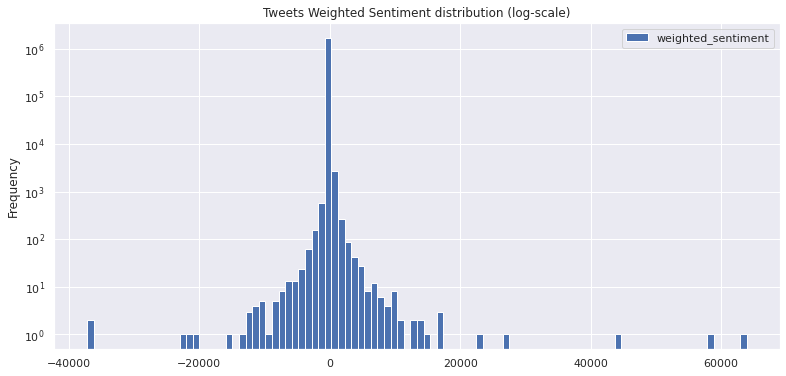

In [15]:
tweets_df[["weighted_sentiment"]].plot.hist(bins=100,
                                            logy=True,
                                            title="Tweets Weighted Sentiment distribution (log-scale)");

In [16]:
## Aggregate per Day

tweets_sentiment_per_day_df = (tweets_df
                              .groupby('created_at_date')
                              .agg({'sentiment':["min", "mean","median","max"]}))

tweets_sentiment_per_day_df = tweets_sentiment_per_day_df.reset_index()

tweets_sentiment_per_day_df.columns = ["_".join(x) for x in tweets_sentiment_per_day_df.columns]
tweets_sentiment_per_day_df = tweets_sentiment_per_day_df.rename(columns={"created_at_date_":"created_at_date"})

In [17]:
tweets_sentiment_per_day_df.head()

created_at_date  sentiment_min  sentiment_mean  sentiment_median  \
0      2021-01-01       -0.99978         0.01014           0.01412   
1      2021-01-02       -0.99981        -0.00276          -0.01056   
2      2021-01-03       -0.99955        -0.00151           0.00180   
3      2021-01-04       -0.99896        -0.00517          -0.00381   
4      2021-01-05       -0.99993         0.02736           0.03837   

   sentiment_max  
0        0.99931  
1        0.99962  
2        0.99985  
3        0.99959  
4        0.99981

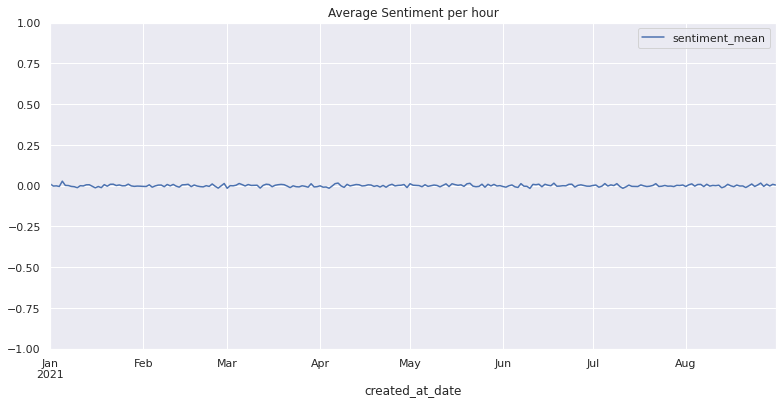

In [18]:
# Plot Average sentiment
ax1 = tweets_sentiment_per_day_df.plot.line(x="created_at_date",
                                            y="sentiment_mean",
                                            title="Average Sentiment per hour", ylim=[-1,1]);

## Combine datasets [binance_df, tweets_sentiment_per_day_df]

In [83]:
binance_df.head()

open_time               close_time  \
2020-12-10 01:59:59.999  2020-12-09 00:00:00.000  2020-12-09 23:59:59.999   
2020-12-11 01:59:59.999  2020-12-10 00:00:00.000  2020-12-10 23:59:59.999   
2020-12-12 01:59:59.999  2020-12-11 00:00:00.000  2020-12-11 23:59:59.999   
2020-12-13 01:59:59.999  2020-12-12 00:00:00.000  2020-12-12 23:59:59.999   
2020-12-14 01:59:59.999  2020-12-13 00:00:00.000  2020-12-13 23:59:59.999   

                             open      high       low     close       volume  \
2020-12-10 01:59:59.999 554.92000 578.08000 530.43000 573.09000 997192.16738   
2020-12-11 01:59:59.999 573.20000 575.70000 548.11000 558.99000 608414.51466   
2020-12-12 01:59:59.999 558.99000 560.80000 535.50000 544.43000 768921.78317   
2020-12-13 01:59:59.999 544.46000 574.00000 543.10000 568.04000 573913.95311   
2020-12-14 01:59:59.999 568.09000 595.00000 563.22000 590.70000 657794.46158   

                         num_trades  MA_10  STD_10  Price_Change  \
2020-12-10 01:59:59.999      535975    NaN     NaN           NaN   
2020-12-11 01:59:59.999      376548    NaN     NaN     -14.10000   
2020-12-12 01:59:59.999      400545    NaN     NaN     -14.56000   
2020-12-13 01:59:59.999      321104    NaN     NaN      23.61000   
2020-12-14 01:59:59.999      359525    NaN     NaN      22.66000   

                         Price_Change%   Change  upper_bound  lower_bound  \
2020-12-10 01:59:59.999            NaN      NaN          NaN          NaN   
2020-12-11 01:59:59.999       -2.46000  Neutral          NaN          NaN   
2020-12-12 01:59:59.999       -2.60000  Neutral          NaN          NaN   
2020-12-13 01:59:59.999        4.34000  Neutral          NaN          NaN   
2020-12-14 01:59:59.999        3.99000  Neutral          NaN          NaN   

                         above_bound  below_bound open_time_date cross_bounds  
2020-12-10 01:59:59.999        False        False     2020-12-09      neutral  
2020-12-11 01:59:59.999        False        False     2020-12-10      neutral  
2020-12-12 01:59:59.999        False        False     2020-12-11      neutral  
2020-12-13 01:59:59.999        False        False     2020-12-12      neutral  
2020-12-14 01:59:59.999        False        False     2020-12-13      neutral

In [84]:
tweets_sentiment_per_day_df.head()

created_at_date  sentiment_min  sentiment_mean  sentiment_median  \
0      2021-01-01       -0.99978         0.01014           0.01412   
1      2021-01-02       -0.99981        -0.00276          -0.01056   
2      2021-01-03       -0.99955        -0.00151           0.00180   
3      2021-01-04       -0.99896        -0.00517          -0.00381   
4      2021-01-05       -0.99993         0.02736           0.03837   

   sentiment_max  
0        0.99931  
1        0.99962  
2        0.99985  
3        0.99959  
4        0.99981

In [85]:
# Merge dataset
df = binance_df.merge(tweets_sentiment_per_day_df,
                      left_on = "open_time_date",
                      right_on = "created_at_date",
                      how="inner")

In [86]:
# Check shape (8 months x ~30 days)
df.shape

(243, 24)

# Correlation Analysis

In [87]:
# Check dataset
df.head()

open_time               close_time       open       high  \
0  2021-01-01 00:00:00.000  2021-01-01 23:59:59.999  736.42000  749.00000   
1  2021-01-02 00:00:00.000  2021-01-02 23:59:59.999  728.91000  787.69000   
2  2021-01-03 00:00:00.000  2021-01-03 23:59:59.999  774.44000 1011.07000   
3  2021-01-04 00:00:00.000  2021-01-04 23:59:59.999  978.33000 1162.97000   
4  2021-01-05 00:00:00.000  2021-01-05 23:59:59.999 1041.45000 1134.60000   

        low      close        volume  num_trades     MA_10    STD_10  \
0 714.29000  728.91000  675114.09329      483671 682.71500  61.57362   
1 714.91000  774.56000 1352618.57668      824134 701.61500  57.29660   
2 768.71000  978.28000 2813603.88615     1636501 738.21200  97.02282   
3 890.00000 1041.43000 4245010.94004     2477862 779.67300 127.82961   
4 974.45000 1099.56000 2706995.67525     1960503 825.88500 151.95235   

   Price_Change  Price_Change%    Change  upper_bound  lower_bound  \
0      -7.51000       -1.02000   Neutral    805.86224    559.56776   
1      45.65000        6.26000  Increase    816.20821    587.02179   
2     203.72000       26.30000  Increase    932.25763    544.16637   
3      63.15000        6.46000  Increase   1035.33221    524.01379   
4      58.13000        5.58000  Increase   1129.78970    521.98030   

   above_bound  below_bound open_time_date cross_bounds created_at_date  \
0        False        False     2021-01-01      neutral      2021-01-01   
1        False        False     2021-01-02      neutral      2021-01-02   
2         True        False     2021-01-03        above      2021-01-03   
3         True        False     2021-01-04        above      2021-01-04   
4         True        False     2021-01-05        above      2021-01-05   

   sentiment_min  sentiment_mean  sentiment_median  sentiment_max  
0       -0.99978         0.01014           0.01412        0.99931  
1       -0.99981        -0.00276          -0.01056        0.99962  
2       -0.99955        -0.00151           0.00180        0.99985  
3       -0.99896        -0.00517          -0.00381        0.99959  
4       -0.99993         0.02736           0.03837        0.99981

## For all days

**Correlations**

1. [Price_Change, Price_Change%], Sentiment_mean


**Plots**

1. Scatter plot (Price Change, Sentiment Mean)

In [88]:
# Price Change and Average sentiment per Day
df[["open_time_date",
    "close", "Price_Change", "Price_Change%", "cross_bounds",
    "sentiment_mean"]]

open_time_date      close  Price_Change  Price_Change% cross_bounds  \
0       2021-01-01  728.91000      -7.51000       -1.02000      neutral   
1       2021-01-02  774.56000      45.65000        6.26000      neutral   
2       2021-01-03  978.28000     203.72000       26.30000        above   
3       2021-01-04 1041.43000      63.15000        6.46000        above   
4       2021-01-05 1099.56000      58.13000        5.58000        above   
..             ...        ...           ...            ...          ...   
238     2021-08-27 3273.45000     180.25000        5.83000      neutral   
239     2021-08-28 3244.48000     -28.97000       -0.88000      neutral   
240     2021-08-29 3223.47000     -21.01000       -0.65000      neutral   
241     2021-08-30 3229.64000       6.17000        0.19000        above   
242     2021-08-31 3429.20000     199.56000        6.18000        above   

     sentiment_mean  
0           0.01014  
1          -0.00276  
2          -0.00151  
3          -0.00517  
4           0.02736  
..              ...  
238        -0.00489  
239         0.00896  
240        -0.00225  
241         0.00781  
242         0.00364  

[243 rows x 6 columns]

In [95]:
# Scatter Plot
fig = px.scatter(df,
                 x="Price_Change", y="sentiment_mean",
                 color="cross_bounds",
                 hover_name="open_time_date",
                 title="Price Change vs Average Sentiment")

fig.show()

In [94]:
print("Correlation between Price Change and Average Sentiment")
df[["Price_Change","sentiment_mean"]].corr()

Correlation between Price Change and Average Sentiment


Price_Change  sentiment_mean
Price_Change         1.00000        -0.07790
sentiment_mean      -0.07790         1.00000

## Intra day

In [102]:
# Extract tweets for specifc date
select_date = "2021-05-13"
intra_day_tweets = tweets_df.query("created_at_date == @select_date")
print(f"There are {len(intra_day_tweets)} tweets for this date")

There are 7139 tweets for this date


In [106]:
# "like_count", "quote_count", "reply_count", "retweet_count"
intra_day_tweets.sort_values("like_count", ascending=False).head(5)

author_id                created_at             tweet_id  \
910351  1173425402523652096 2021-05-13 20:58:12+00:00  1392947307151335432   
905820  1184294344984952833 2021-05-13 04:43:55+00:00  1392702119732334594   
910354   943506806931734528 2021-05-13 20:58:07+00:00  1392947286188060673   
910804             30325257 2021-05-13 21:50:11+00:00  1392960389365653509   
905962   943506806931734528 2021-05-13 05:53:27+00:00  1392719618632916994   

                                                     text  like_count  \
910351  💧nftmall 2nd round airdrop💧\n\n🏆 task:        ...        3809   
905820  $1000 to one person in 7 days\n\nretweet &amp;...        3134   
910354  no projects come close to $btc and $eth in ter...        3126   
910804     #ethereum needs to move to proof of stake asap        3022   
905962  anyone else impressed how bullish $eth remains...        2390   

        quote_count  reply_count  retweet_count created_at_date  \
910351          391          276           4036      2021-05-13   
905820           25         3462           6217      2021-05-13   
910354           16          371            255      2021-05-13   
910804           10          204            148      2021-05-13   
905962            1          129             73      2021-05-13   

       created_at_date_hour  sentiment sentiment_val  weighted_sentiment  
910351        2021-05-13 20   -0.17078      negative         -1339.80575  
905820         2021-05-13 4   -0.96651      negative         -9037.85655  
910354        2021-05-13 20    0.84332      positive          2851.27627  
910804        2021-05-13 21   -0.53164      negative         -1685.29602  
905962         2021-05-13 5   -0.90415      negative         -2226.91321

In [108]:
# Plot: Check most liked tweets
fig = px.line(idntra_day_tweets,
              x="created_at", y="like_count",
              title=f'{select_date} | Intra-day Likes on tweets',
              hover_name="author_id", # username
              hover_data=["created_at", "like_count","tweet_id","text"])
fig.show()

In [112]:
# Plot: Sentiment vs Likes

fig = px.scatter(intra_day_tweets,
                 x="sentiment", y="like_count",
                 title=f'{select_date} | Sentiment vs Likes',
                 hover_name="author_id", # username
                 hover_data=["created_at", "like_count","tweet_id","text"])
fig.show()

In [114]:
intra_day_tweets[["like_count","sentiment"]].corr()

like_count  sentiment
like_count     1.00000   -0.01471
sentiment     -0.01471    1.00000

# LEGACY CODE

In [92]:
## Plot
# fig = go.Figure()

# # Add traces
# fig.add_trace(go.Scatter(x=df["Price_Change"], # Price_Change%
#                          y=df["sentiment_mean"],
#                          marker_color=df['cross_bounds'].astype(int),
#                          mode='markers',
#                          name='Dates',
#                          text=df['Price_Change%']))

# fig.update_layout(
#     xaxis_title="Price Change",
#     yaxis_title="Average Sentiment",
#     title={'text': "Price Change vs Average Sentiment"})


# fig.show()